In [2]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
import gseapy as gp


In [ ]:
with open('output/post_rev_comb_threshold_dict_nodes_homomouse_EEN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_nodes_EEN_ji = pk.load(handle)
    
with open('output/post_rev_comb_threshold_dict_edges_homomouse_EEN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_edges_EEN_ji = pk.load(handle)

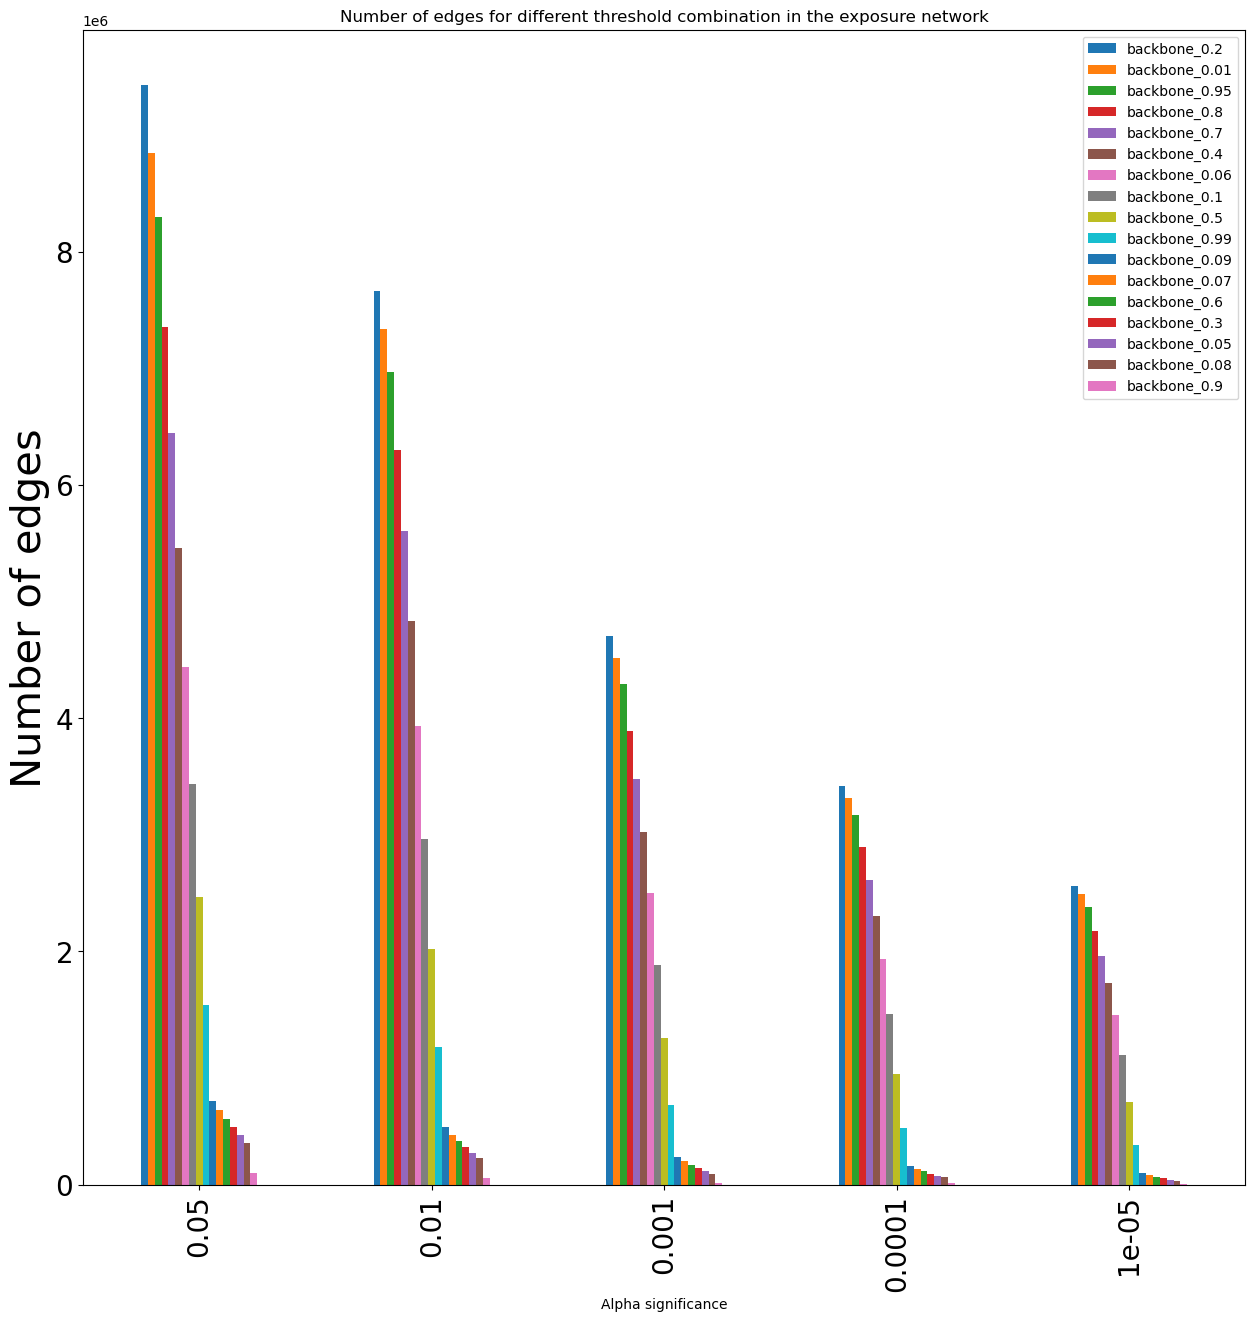

In [ ]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_edges_EEN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_edges_EEN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_edges_EEN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of edges for different threshold combination in the exposure network')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of edges',fontsize=30)
plt.savefig('output/Figures/HomoMouse_cutoffcalibration_EEN_edges.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

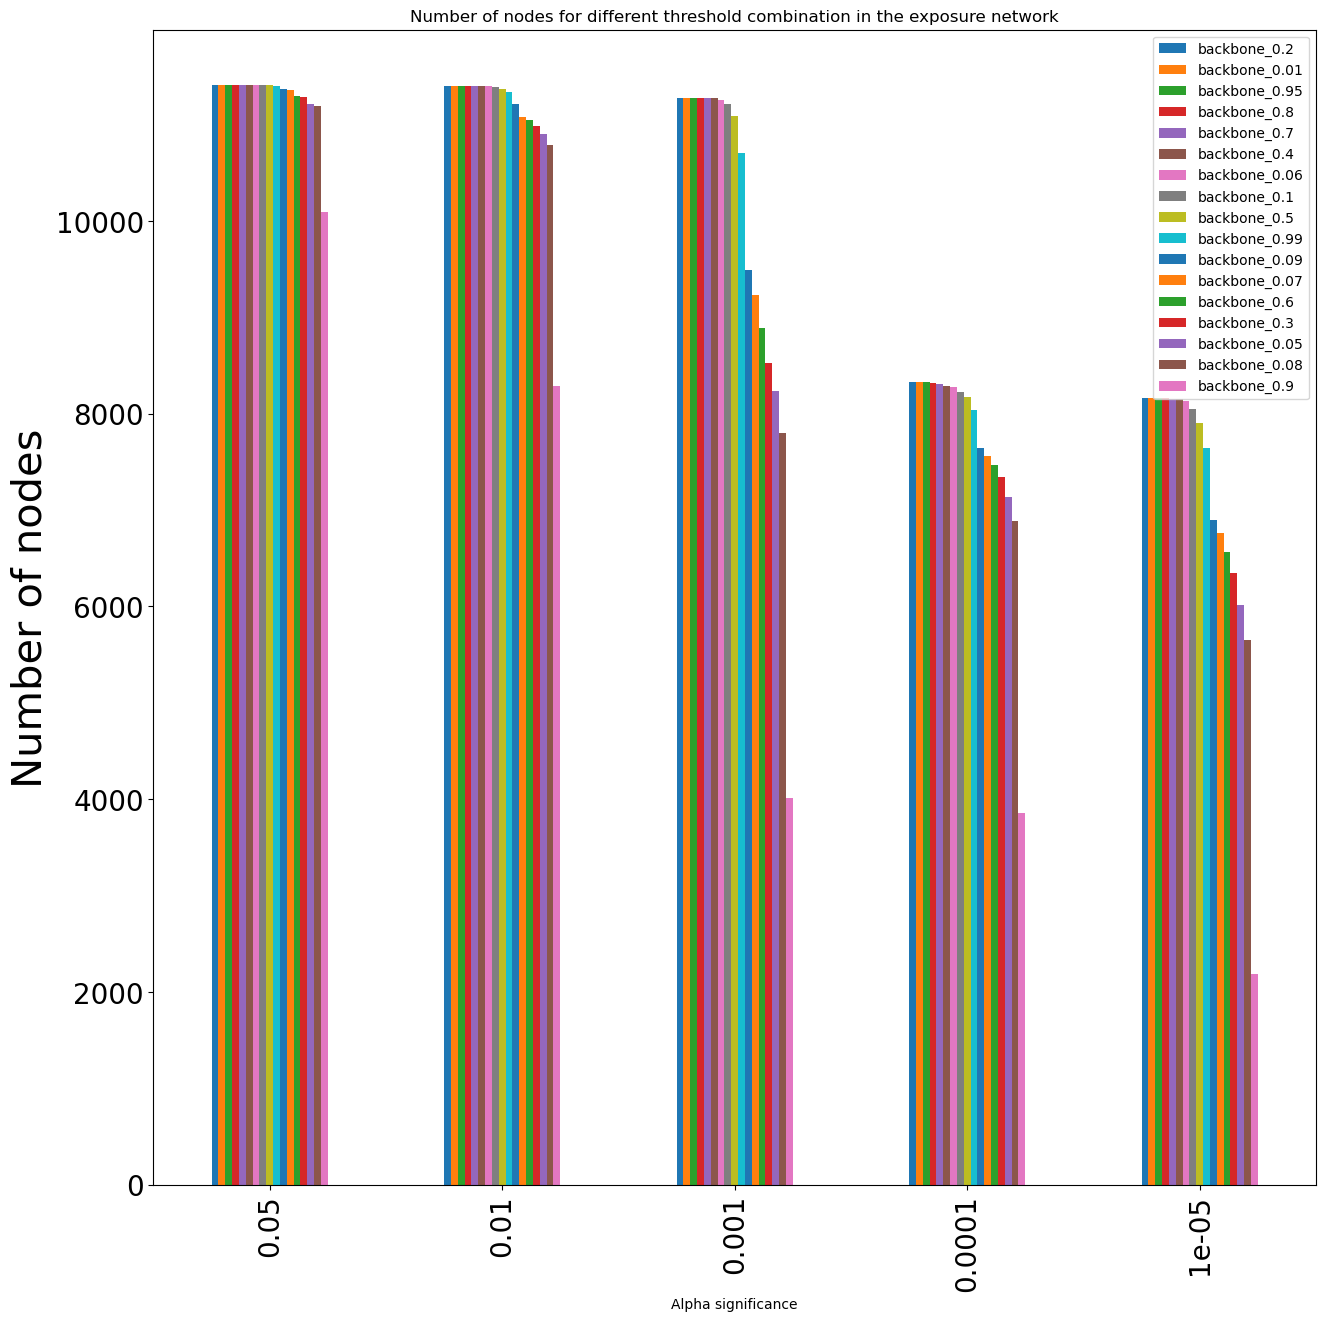

In [ ]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_nodes_EEN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_nodes_EEN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_nodes_EEN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of nodes for different threshold combination in the exposure network')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of nodes',fontsize=30)
plt.savefig('output/Figures/HomoMouse_cutoffcalibration_EEN_nodes.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

In [6]:
for k,v in comb_threshold_dict_edges_EEN_ji.items():
    if v<900000 and comb_threshold_dict_nodes_EEN_ji[k]>11000:
        print(k,comb_threshold_dict_nodes_EEN_ji[k],v)

('fdr_0.05', 'backbone_0.1') 11367 713596
('fdr_0.05', 'backbone_0.09') 11355 640042
('fdr_0.05', 'backbone_0.08') 11296 562799
('fdr_0.05', 'backbone_0.07') 11290 491738
('fdr_0.05', 'backbone_0.06') 11211 423265
('fdr_0.05', 'backbone_0.05') 11193 355176
('fdr_0.01', 'backbone_0.1') 11219 496684
('fdr_0.01', 'backbone_0.09') 11077 430382
('fdr_0.01', 'backbone_0.08') 11048 375645


In [12]:
#In the homo version we kept 9767 out of the 9887, we can maintain a similar proportion of lost nodes (~1%), which means around 114 nodes, with a ratio node/edges ~0.01
#Based on these considerations we are going to use the FDR=0.05 and backbone_0.09
11355/640042


0.017741023245349524

In [14]:
#Let's import it
backbone_homomouse_exp_graph_significant_weighted = nx.read_weighted_edgelist("backbone_homomouse_exp_graph_significant_weighted.edgelist")

In [15]:
from community import community_louvain

#Here, we find the resolution parameter that optimizes Newman's modularity
def optimal_resolution_with_diagnostics_simple_network(G, resolution_list,weight,rd_state):
    max_modularity = -1
    modularity_scores = []
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=rd_state)
        modularity = community_louvain.modularity(partition,G)
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
        modularity_scores.append((resolution, modularity))
    return best_partition, best_resolution, max_modularity, modularity_scores

#Here, we define a function that allows us to select the resolution parameter that corresponds to the 
#maximum value of modularity

def optimal_resolution(G, resolution_list,weight,random_state):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """
    res_mod_dict = {}
    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=random_state)
        modularity = community_louvain.modularity(partition,G)
        res_mod_dict[resolution] = modularity

        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity,res_mod_dict

In [16]:
resolution_list = np.linspace(0.1, 2, 20) 

best_partition, best_resolution, max_modularity, res_mod_dict = optimal_resolution(backbone_homomouse_exp_graph_significant_weighted, resolution_list,'weight',5495)
print('Optimal resolution value: ', best_resolution)

Optimal resolution value:  1.0999999999999999


In [17]:
dendo = community_louvain.generate_dendrogram(backbone_homomouse_exp_graph_significant_weighted,resolution=1.1 ,weight='weight',random_state=5495)

In [18]:
#There are three hierarchical levels
len(dendo)

3

In [19]:
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   

for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list
    
ee_first_louvain_iteration={}  #this dictionary contains the middle-hierarchical level as keys and the respective (dividing)
                               #finest (first) hierarchical communities as values
for com in set(list(dendo[1].values())):
    exp_list=[]
    for exp, comcom in dendo[1].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration[com]=exp_list
    
ee_second_louvain_iteration={} #this dictionary has the broad-hierarchical (third) level as keys and the respective (dividing)
                               #middle (second) hierarchical communities as values
for com in set(list(dendo[2].values())):
    exp_list=[]
    for exp, comcom in dendo[2].items():
        if com==comcom:
            exp_list.append(exp)
    ee_second_louvain_iteration[com]=exp_list

In [20]:
#These communities are the middle and the broad level related to each community

ee_second_louvain_iteration_exposures={}  
for com, com_list in ee_first_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_first_louvain_iteration_exposures[comcom])
    ee_second_louvain_iteration_exposures[com]=exp_list

ee_third_louvain_iteration_exposures={}
for com, com_list in ee_second_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_second_louvain_iteration_exposures[comcom])
    ee_third_louvain_iteration_exposures[com]=exp_list

In [21]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k

In [22]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_louvain_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

15
61
526


In [ ]:
fine_grained_communities_dict={}
middle_communities_dict={}
broad_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_louvain_sort[com]
    
for com in middle_communities_set:
    middle_communities_dict[com]=renamed_second_level_louvain_sort[com]

for com in broad_communities_set:
    broad_communities_dict[com]=renamed_third_level_louvain_sort[com]
    
with open('output/Communities/Extended/homomouse_weighted_ji_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/homomouse_weighted_ji_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/homomouse_weighted_ji_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
with open('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_broad_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_middle_communities_dict = pk.load(handle)

In [ ]:
with open('output/Communities/Extended/homomouse_weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Extended/homomouse_weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)

with open('output/Communities/Extended/homomouse_weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)

In [25]:
#Global comparison

In [104]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*fine_grained_communities_dict.values()) & set().union(*original_weighted_ji_fine_grained_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in fine_grained_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_fine_grained_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.5402100417468927
AMI: 0.711272554862129


In [105]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*middle_communities_dict.values()) & set().union(*original_weighted_ji_middle_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in middle_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_middle_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.598139301299031
AMI: 0.6249141549604149


In [106]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*broad_communities_dict.values()) & set().union(*original_weighted_ji_broad_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in broad_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_broad_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.49763822449764256
AMI: 0.5380846934004084


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def jaccard(a, b):
    return len(a & b) / len(a | b) if a | b else 0

# community lists
A_keys, B_keys = list(broad_communities_dict.keys()), list(original_weighted_ji_broad_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(broad_communities_dict[kA]), set(original_weighted_ji_broad_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

broad_homomouse_louvain_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/broad_homomouse_louvain_com_ji_list.txt', 'w') as f:
    for line in broad_homomouse_louvain_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(middle_communities_dict.keys()), list(original_weighted_ji_middle_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(middle_communities_dict[kA]), set(original_weighted_ji_middle_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

intermediate_homomouse_louvain_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/intermediate_homomouse_louvain_com_ji_list.txt', 'w') as f:
    for line in intermediate_homomouse_louvain_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(fine_grained_communities_dict.keys()), list(original_weighted_ji_fine_grained_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(fine_grained_communities_dict[kA]), set(original_weighted_ji_fine_grained_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]
finegrained_homomouse_louvain_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/finegrained_homomouse_louvain_com_ji_list.txt', 'w') as f:
    for line in finegrained_homomouse_louvain_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

0.27887420116652606
0.369537439119843
0.6235541993851883


In [33]:
#Let's cluster with Infomap
import infomap
from infomap import Infomap

In [34]:
im = Infomap(silent=True)
mapping = im.add_networkx_graph(backbone_homomouse_exp_graph_significant_weighted, weight='weight')
im.run()


In [35]:
backbone_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    backbone_node_com_dict[mapping[node]]=list(modules)

In [36]:
tot_com_list=[]
for node,com_list in backbone_node_com_dict.items():
    tot_com_list.extend(com_list)
print(len(set(tot_com_list)))  #This is the total number of communities

backbone_com_node_dict={}
for com in set(tot_com_list):
    node_list=[]
    for node,com_list in backbone_node_com_dict.items():
        if com in com_list:
            node_list.append(node)
    backbone_com_node_dict[com]=node_list

521


In [37]:
first_iteration_infomap={}
second_iteration_infomap={}
third_iteration_infomap={}
fourth_iteration_infomap={}

for com in set(im.get_modules(depth_level=1).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=1).items():
        if com==com1:
            node_list.append(mapping[node])
    first_iteration_infomap[com]=node_list 
    
    
for com in set(im.get_modules(depth_level=2).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=2).items():
        if com==com1:
            node_list.append(mapping[node])
    second_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=3).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=3).items():
        if com==com1:
            node_list.append(mapping[node])
    third_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=4).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=4).items():
        if com==com1:
            node_list.append(mapping[node])
    fourth_iteration_infomap[com]=node_list

In [38]:
len(first_iteration_infomap)

83

In [39]:
len(second_iteration_infomap)

483

In [40]:
len(third_iteration_infomap)

521

In [41]:
len(fourth_iteration_infomap)

521

In [42]:
#These communities are the middle and the broad level related to each community

ee_first_level_infomap={}  #middle to fine
for comcom, explist1 in second_iteration_infomap.items():
    comlist=[]
    for com, explist2 in third_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_first_level_infomap[comcom]=comlist

ee_second_level_infomap={}  #broad to middle
for comcom, explist1 in first_iteration_infomap.items():
    comlist=[]
    for com, explist2 in second_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_second_level_infomap[comcom]=comlist

In [44]:

first_level_infomap = third_iteration_infomap
second_level_infomap = second_iteration_infomap
third_level_infomap = first_iteration_infomap




In [45]:
#Let's change the names of these communities based on their size

#BROADEST==third
third_level_infomap_sort=dict(sorted(third_level_infomap.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_infomap_sort={}
c=1
for com,explist in third_level_infomap_sort.items():
    renamed_third_level_infomap_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_infomap_sort={}

for br_com,mid_com in ee_second_level_infomap.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_infomap_sort[newcom]=second_level_infomap[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(second_level_infomap[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_infomap_sort[newcom]=second_level_infomap[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_infomap_sort={}

for mid_com,fin_com in ee_first_level_infomap.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_infomap_sort[newcom]=first_level_infomap[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(first_level_infomap[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_infomap_sort[newcom]=first_level_infomap[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom

In [46]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_infomap_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

5
24
521


In [ ]:
fine_grained_communities_dict={}
middle_communities_dict={}
broad_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_infomap_sort[com]
    
for com in middle_communities_set:
    try:
        middle_communities_dict[com]=renamed_second_level_infomap_sort[com]
    except:
        middle_communities_dict[com]=renamed_third_level_infomap_sort[com]

for com in broad_communities_set:
    broad_communities_dict[com]=renamed_third_level_infomap_sort[com]
    
with open('output/Communities/Extended/homomousebipartite_infomap_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/homomousebipartite_infomap_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/homomousebiprtite_infomap_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_broad_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_middle_communities_dict = pk.load(handle)

    

In [ ]:
with open('output/Communities/Extended/homomousebipartite_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Extended/homomousebipartite_infomap_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)

with open('output/Communities/Extended/homomousebiprtite_infomap_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)


In [ ]:
#Global comparison

In [110]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*fine_grained_communities_dict.values()) & set().union(*original_weighted_ji_fine_grained_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in fine_grained_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_fine_grained_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.5093419533895859
AMI: 0.7057343956049026


In [111]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*middle_communities_dict.values()) & set().union(*original_weighted_ji_middle_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in middle_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_middle_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.6547214837817839
AMI: 0.5277411050067593


In [112]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*broad_communities_dict.values()) & set().union(*original_weighted_ji_broad_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in broad_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_broad_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.6369614988063698
AMI: 0.4942842841484923


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def jaccard(a, b):
    return len(a & b) / len(a | b) if a | b else 0

# community lists
A_keys, B_keys = list(broad_communities_dict.keys()), list(original_weighted_ji_broad_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(broad_communities_dict[kA]), set(original_weighted_ji_broad_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

broad_homomouse_infomap_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/broad_homomouse_infomap_com_ji_list.txt', 'w') as f:
    for line in broad_homomouse_infomap_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(middle_communities_dict.keys()), list(original_weighted_ji_middle_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(middle_communities_dict[kA]), set(original_weighted_ji_middle_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

intermediate_homomouse_infomap_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/intermediate_homomouse_infomap_com_ji_list.txt', 'w') as f:
    for line in intermediate_homomouse_infomap_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(fine_grained_communities_dict.keys()), list(original_weighted_ji_fine_grained_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(fine_grained_communities_dict[kA]), set(original_weighted_ji_fine_grained_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]
finegrained_homomouse_infomap_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/finegrained_homomouse_infomap_com_ji_list.txt', 'w') as f:
    for line in finegrained_homomouse_infomap_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

0.4438117915086755
0.21423248625406957
0.5342006596376366


In [121]:
#Let's prepare the communities for the enrichment



def read_gene_annotation(file_path):
    """
    Reads a gene annotation file and stores it as a dictionary.
    
    Parameters:
        file_path (str): Path to the input text file.
        
    Returns:
        dict: Dictionary where keys are annotations and values are lists of genes.
    """
    gene_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')  # Split by tab
            if len(parts) > 1:
                annotation = parts[0].strip()
                genes = [gene.strip() for gene in parts[1:] if gene.strip()]
                gene_dict[annotation] = genes
    
    return gene_dict


In [ ]:
#Let's read the annotations files
MF2023_gene_dict = read_gene_annotation("input/Libraries/GO_Molecular_Function_2023.txt")
CC2023_gene_dict = read_gene_annotation("input/Libraries/GO_Cellular_Component_2023.txt")
BP2023_gene_dict = read_gene_annotation("input/Libraries/GO_Biological_Process_2023.txt")
Reactome2024_gene_dict = read_gene_annotation("input/Libraries/Reactome_Pathways_2024.txt")

In [123]:
tot_gene_annotation_dict = {**MF2023_gene_dict, **CC2023_gene_dict, **BP2023_gene_dict, **Reactome2024_gene_dict}

In [ ]:
with open("input/Libraries/genetic_background.txt", "r") as file:
    genetic_background_list = [line.strip() for line in file]

In [ ]:
#Here we define open the communities

with open('output/Communities/Extended/homomouse_weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    ee_first_louvain_iteration_exposures = pk.load(handle)

with open('output/Communities/Extended/homomouse_weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    ee_second_louvain_iteration_exposures = pk.load(handle)

with open('output/Communities/Extended/homomouse_weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    ee_third_louvain_iteration_exposures = pk.load(handle)

In [ ]:

#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo_mouse = chem_gene_df[chem_gene_df['Organism'].isin(['Homo sapiens', 'Mus musculus'])]

#Let's create a new dictionary that contains only those chemical-gene interactions that have at least >1 reference 
#(in this way, we remove the majority of the interactions already)
chem_gene_homo_mouse = {}
for i,v in chem_homo_mouse.iterrows():
    try:
        chem_gene_homo_mouse[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene_homo_mouse[v["ChemicalID"]] = set([v["GeneSymbol"]])
        

chem_gene_homomouse_cleaned = {}
tot_gene_homomouse_list=[]
for chem,gene_list in chem_gene_homo_mouse.items():
    n_genelist = [n for n in gene_list if str(n)!='nan']
    tot_gene_homomouse_list.extend(n_genelist)
    if len(n_genelist)>0:
        chem_gene_homomouse_cleaned[chem] = set(n_genelist)


In [127]:

#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_first_louvain_cluster_genelist={}
for com,explist in ee_first_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_homomouse_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_homomouse_cleaned[edge[0]] & chem_gene_homomouse_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_homomouse_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_first_louvain_cluster_genelist[com]=rank_genelist

pre_rank_first_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_first_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_first_louvain_cluster_genelist_df[com]=rank_df

pre_rank_second_louvain_cluster_genelist={}
for com,explist in ee_second_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_homomouse_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_homomouse_cleaned[edge[0]] & chem_gene_homomouse_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_homomouse_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_second_louvain_cluster_genelist[com]=rank_genelist

pre_rank_second_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_second_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_second_louvain_cluster_genelist_df[com]=rank_df

pre_rank_third_louvain_cluster_genelist={}
for com,explist in ee_third_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_homomouse_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_homomouse_cleaned[edge[0]] & chem_gene_homomouse_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_homomouse_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_third_louvain_cluster_genelist[com]=rank_genelist

pre_rank_third_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_third_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_third_louvain_cluster_genelist_df[com]=rank_df


In [128]:
library_list = ["GO_Molecular_Function_2025","GO_Biological_Process_2025","GO_Cellular_Component_2025","Reactome_Pathways_2024"]
def enr_ranking_leading_genes(pre_rank_df,library_list):   #This function returns the leading genes
    import gseapy as gp 
    leading_genes_tot=[]
    for lib in library_list:
        c=0
        while c<10:
            try:
                lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
                                 processes=4,min_size=3,max_size=5000,outdir=None,   #we impose at least 5 enriched common genes
                                 permutation_num=500) # reduce number to speed up testing
                leading_gene_lib_list=[]
                for gene_str in lib_pre_res.res2d['Lead_genes'].tolist():    #lib_pre_res.res2d['Lead_genes'] if in the cluster
                    leading_gene_lib_list.extend(gene_str.split(";"))
                leading_genes_tot.extend(leading_gene_lib_list)
                if 'Lead_genes' in lib_pre_res.res2d:
                    break
            except (NameError, AttributeError):
                c += 1
    return set(leading_genes_tot)

In [129]:
#Let's associate for each community the most meaningful genes (those communities associated with more than 20 genes, we will use the leading genes of the ranked enrichment by frequency)
#First louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

first_louvain_cluster_genes = {}
second_louvain_cluster_genes = {}
third_louvain_cluster_genes = {}

for com in list(pre_rank_first_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_first_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_first_louvain_cluster_genelist_df[com],library_list))
            first_louvain_cluster_genes[com] = lead_genelist
        except:
            first_louvain_cluster_genes[com] = list(pre_rank_first_louvain_cluster_genelist_df[com]["gene"])
    else:
        first_louvain_cluster_genes[com] = list(pre_rank_first_louvain_cluster_genelist_df[com]["gene"])

#Second louvain interation
for com in list(pre_rank_second_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_second_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_second_louvain_cluster_genelist_df[com],library_list))
            second_louvain_cluster_genes[com] = lead_genelist
        except:
            second_louvain_cluster_genes[com] = list(pre_rank_second_louvain_cluster_genelist_df[com]["gene"])
    else:
        second_louvain_cluster_genes[com] = list(pre_rank_second_louvain_cluster_genelist_df[com]["gene"])
        
#Third louvain interation
for com in list(pre_rank_third_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_third_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_third_louvain_cluster_genelist_df[com],library_list))
            third_louvain_cluster_genes[com] = lead_genelist
        except:
            third_louvain_cluster_genes[com] = list(pre_rank_third_louvain_cluster_genelist_df[com]["gene"])
    else:
        third_louvain_cluster_genes[com] = list(pre_rank_third_louvain_cluster_genelist_df[com]["gene"])

        

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_29919/3570246027.py:9: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-09-07 15:25:38,362 [WARNING] Duplicated values found in preranked stats: 77.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_29919/3570246027.py:9: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-09-07 15:25:38,390 [WARNING] Duplicated values found in preranked stats: 77.14% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_29919/3570246027.py:9: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-09-07 15:25:38,451 [WARNING] Duplicated values fo

In [ ]:
import json
# Save the JSON data to a file
with open("output/Communities/Extended/homomouse_first_louvain_cluster_genes.json", "w") as f:
    json.dump(first_louvain_cluster_genes, f)
with open("output/Communities/Extended/homomouse_second_louvain_cluster_genes.json", "w") as f:
    json.dump(second_louvain_cluster_genes, f)
with open("output/Communities/Extended/homomouse_third_louvain_cluster_genes.json", "w") as f:
    json.dump(third_louvain_cluster_genes, f)

In [ ]:
#Infomap
with open('output/Communities/Extended/homomousebipartite_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    homomousebipartite_infomap_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Extended/homomousebipartite_infomap_middle_communities_dict.pickle', 'rb') as handle:
    homomousebipartite_infomap_middle_communities_dict = pk.load(handle)

with open('output/Communities/Extended/homomousebiprtite_infomap_broad_communities_dict.pickle', 'rb') as handle:
    homomousebiprtite_infomap_broad_communities_dict = pk.load(handle)


In [132]:

#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_first_infomap_cluster_genelist={}
for com,explist in homomousebipartite_infomap_fine_grained_communities_dict.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_homomouse_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_homomouse_cleaned[edge[0]] & chem_gene_homomouse_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_homomouse_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_first_infomap_cluster_genelist[com]=rank_genelist

pre_rank_first_infomap_cluster_genelist_df={}
for com,genelist in pre_rank_first_infomap_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_first_infomap_cluster_genelist_df[com]=rank_df

pre_rank_second_infomap_cluster_genelist={}
for com,explist in homomousebipartite_infomap_middle_communities_dict.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_homomouse_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_homomouse_cleaned[edge[0]] & chem_gene_homomouse_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_homomouse_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_second_infomap_cluster_genelist[com]=rank_genelist

pre_rank_second_infomap_cluster_genelist_df={}
for com,genelist in pre_rank_second_infomap_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_second_infomap_cluster_genelist_df[com]=rank_df

pre_rank_third_infomap_cluster_genelist={}
for com,explist in homomousebiprtite_infomap_broad_communities_dict.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(backbone_homomouse_exp_graph_significant_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_homomouse_cleaned[edge[0]] & chem_gene_homomouse_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_homomouse_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_third_infomap_cluster_genelist[com]=rank_genelist

pre_rank_third_infomap_cluster_genelist_df={}
for com,genelist in pre_rank_third_infomap_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_third_infomap_cluster_genelist_df[com]=rank_df


In [133]:
#Let's associate for each community the most meaningful genes (those communities associated with more than 20 genes, we will use the leading genes of the ranked enrichment by frequency)
#First louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

first_infomap_cluster_genes = {}
second_infomap_cluster_genes = {}
third_infomap_cluster_genes = {}

for com in list(pre_rank_first_infomap_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_first_infomap_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_first_infomap_cluster_genelist_df[com],library_list))
            first_infomap_cluster_genes[com] = lead_genelist
        except:
            first_infomap_cluster_genes[com] = list(pre_rank_first_infomap_cluster_genelist_df[com]["gene"])
    else:
        first_infomap_cluster_genes[com] = list(pre_rank_first_infomap_cluster_genelist_df[com]["gene"])

#Second louvain interation
for com in list(pre_rank_second_infomap_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_second_infomap_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_second_infomap_cluster_genelist_df[com],library_list))
            second_infomap_cluster_genes[com] = lead_genelist
        except:
            second_infomap_cluster_genes[com] = list(pre_rank_second_infomap_cluster_genelist_df[com]["gene"])
    else:
        second_infomap_cluster_genes[com] = list(pre_rank_second_infomap_cluster_genelist_df[com]["gene"])
        
#Third louvain interation
for com in list(pre_rank_third_infomap_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_third_infomap_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_third_infomap_cluster_genelist_df[com],library_list))
            third_infomap_cluster_genes[com] = lead_genelist
        except:
            third_infomap_cluster_genes[com] = list(pre_rank_third_infomap_cluster_genelist_df[com]["gene"])
    else:
        third_infomap_cluster_genes[com] = list(pre_rank_third_infomap_cluster_genelist_df[com]["gene"])

        

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_29919/3570246027.py:9: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-09-07 15:37:33,047 [WARNING] Duplicated values found in preranked stats: 96.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_29919/3570246027.py:9: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-09-07 15:37:33,110 [WARNING] Duplicated values found in preranked stats: 96.92% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_29919/3570246027.py:9: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-09-07 15:37:33,257 [WARNING] Duplicated values fo

In [ ]:
import json
# Save the JSON data to a file
with open("output/Communities/Extended/homomouse_first_infomap_cluster_genes.json", "w") as f:
    json.dump(first_infomap_cluster_genes, f)
with open("output/Communities/Extended/homomouse_second_infomap_cluster_genes.json", "w") as f:
    json.dump(second_infomap_cluster_genes, f)
with open("output/Communities/Extended/homomouse_third_infomap_cluster_genes.json", "w") as f:
    json.dump(third_infomap_cluster_genes, f)

In [ ]:
#GGN

In [ ]:
with open('output/post_rev_comb_threshold_dict_nodes_homomouse_GGN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_nodes_GGN_ji = pk.load(handle)
    
with open('output/post_rev_comb_threshold_dict_edges_homomouse_GGN_ji.pickle', 'rb') as handle:
    comb_threshold_dict_edges_GGN_ji = pk.load(handle)

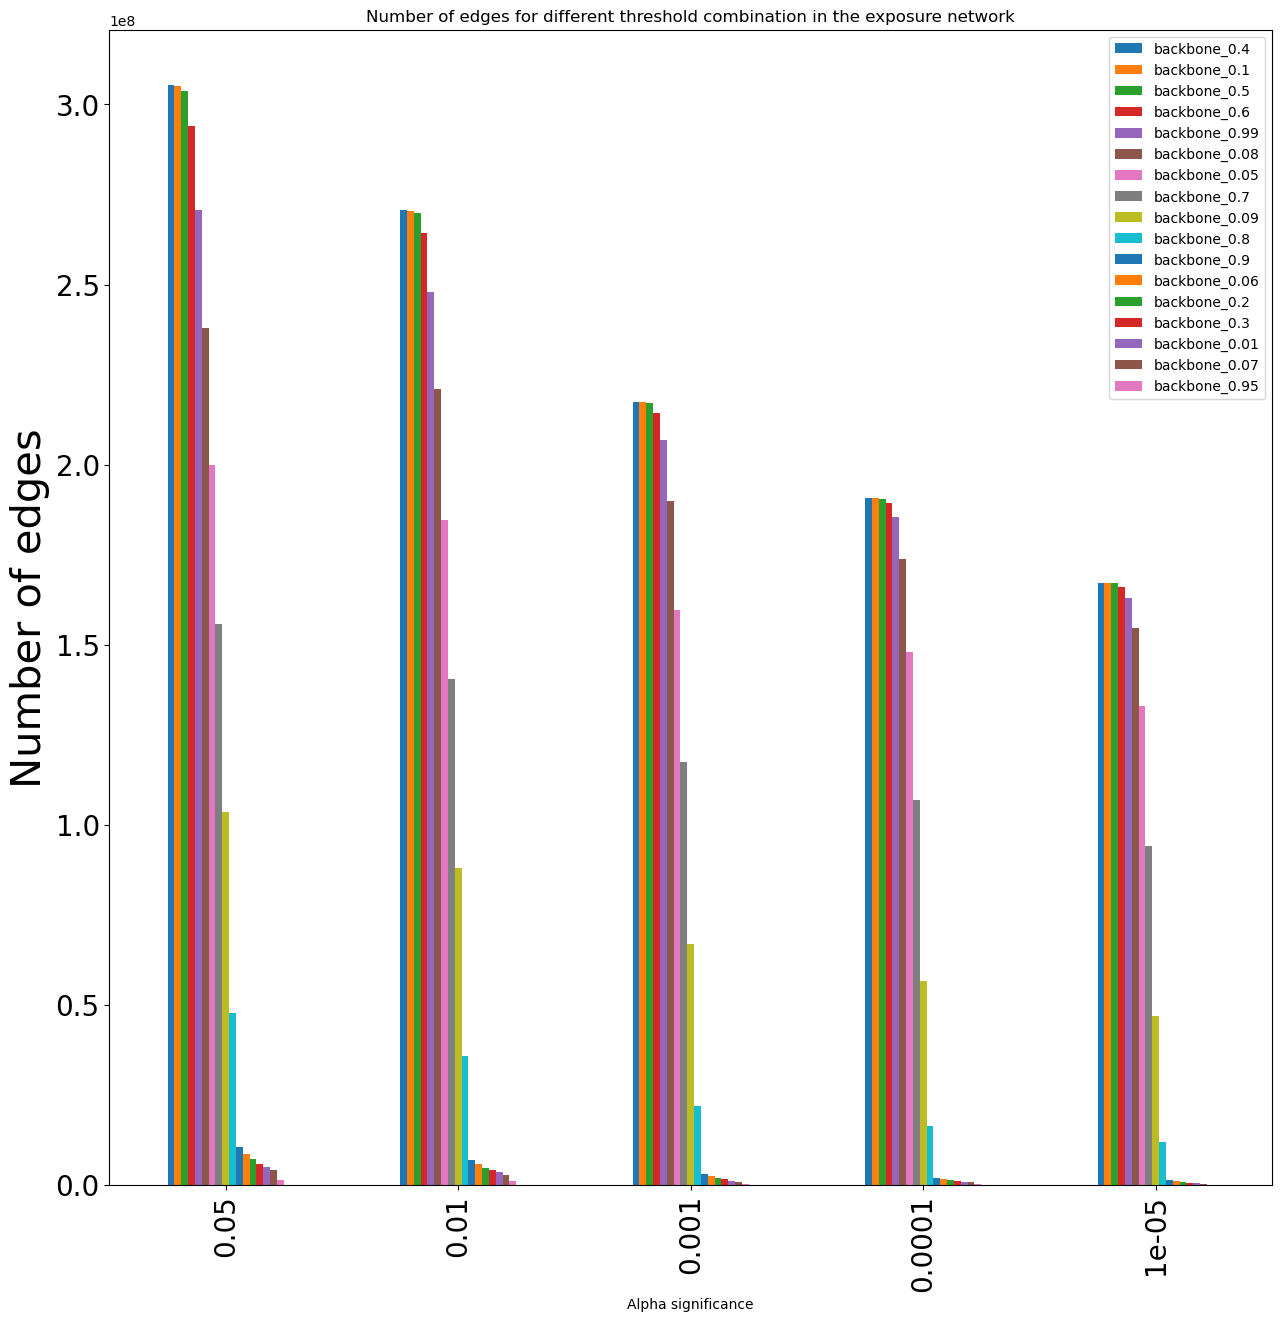

In [ ]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_edges_GGN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_edges_GGN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_edges_GGN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of edges for different threshold combination in the exposure network')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of edges',fontsize=30)
plt.savefig('output/Figures/Homomouse_GGN_cutoff_calibration_edges.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

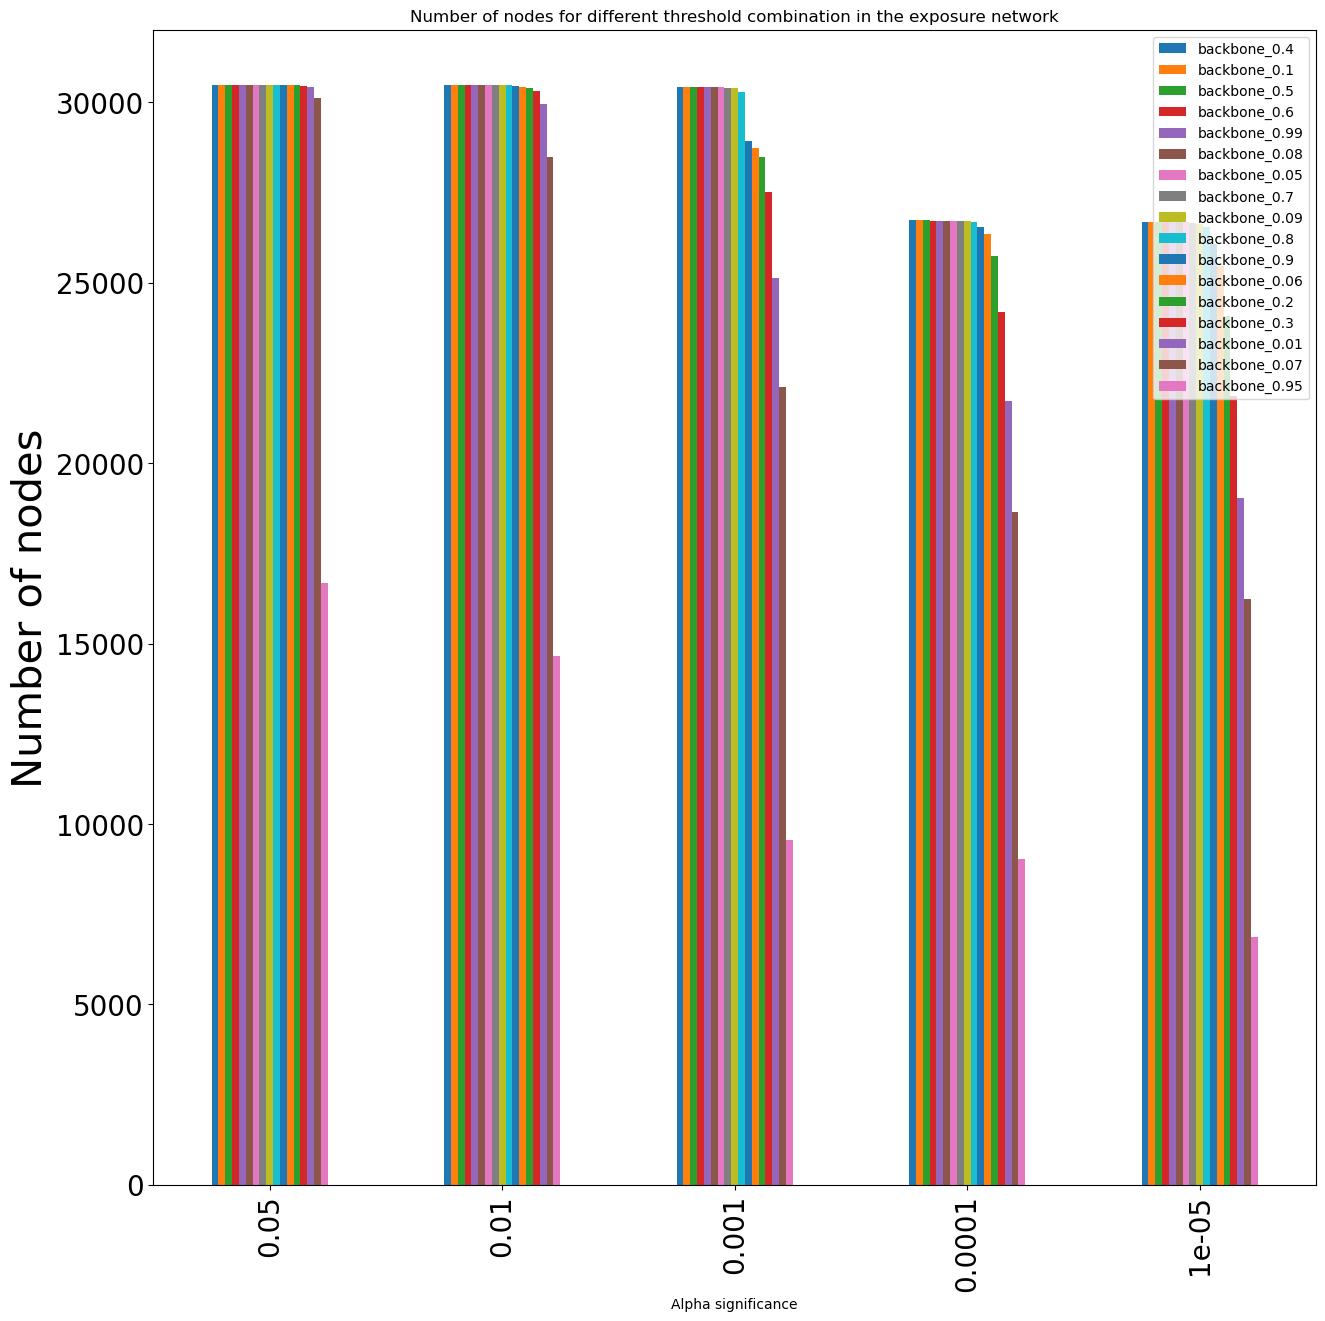

In [ ]:

fdr_keys=set([k[0][4:] for k in comb_threshold_dict_nodes_GGN_ji.keys()])
backbone_keys=set([k[1] for k in comb_threshold_dict_nodes_GGN_ji.keys()])
datalist=[]
for fdr in fdr_keys:
    back_list=[]
    back_list.append(float(fdr))
    for k,v in comb_threshold_dict_nodes_GGN_ji.items():
        if fdr==k[0][4:]:
            back_list.append(float(v))
    datalist.append(back_list)
    
columnlist=['Alpha significance']+list(backbone_keys)
# create data
df = pd.DataFrame(datalist,
                  columns=columnlist)
df_sort=df.sort_values(by=['Alpha significance'],ascending=False)
# plot grouped bar chart
df_sort.plot(x='Alpha significance',
        kind='bar',
        stacked=False,figsize=(15,15),
        title='Number of nodes for different threshold combination in the exposure network')
plt.xticks(fontsize=20) 
plt.yticks(fontsize=20) 
plt.ylabel('Number of nodes',fontsize=30)
plt.savefig('output/Figures/Homomouse_GGN_cutoff_calibration_nodes.pdf',format='pdf',dpi=300, bbox_inches = "tight") #This is the final Fig. 1J
plt.show()
plt.close()

In [10]:
for k,v in comb_threshold_dict_edges_GGN_ji.items():
    if v<2000000 and comb_threshold_dict_nodes_GGN_ji[k]>27000:
        print(k,comb_threshold_dict_nodes_GGN_ji[k],v)

('fdr_0.001', 'backbone_0.08') 28473 1908227
('fdr_0.001', 'backbone_0.07') 27512 1512836


In [ ]:
#In the homo version we kept 22338 out of the 25579, we can maintain a similar proportion of lost nodes (~13%), which means around 2000 nodes, with a ratio node/edges ~0.03
#If we maintain the sparsity we are going to lose 20% of the nodes, for this reason we are going to keep the majority of the nodes but with a denser network
# Based on these considerations we are going to use the FDR=0.001 and backbone_0.08
28473/1908227


0.014921180760989127

In [ ]:
!awk '{print $1, $2, $4}' backbone_homomouse_gene_graph_significant_weighted.edgelist > backbone_homomouse_gene_graph_significant_weighted_cleaned.edgelist

In [ ]:
#Let's import it
backbone_homomouse_gene_graph_significant_weighted = nx.read_weighted_edgelist("backbone_homomouse_gene_graph_significant_weighted_cleaned.edgelist")

In [19]:
from community import community_louvain

#Here, we find the resolution parameter that optimizes Newman's modularity
def optimal_resolution_with_diagnostics_simple_network(G, resolution_list,weight,rd_state):
    max_modularity = -1
    modularity_scores = []
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=rd_state)
        modularity = community_louvain.modularity(partition,G)
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
        modularity_scores.append((resolution, modularity))
    return best_partition, best_resolution, max_modularity, modularity_scores

#Here, we define a function that allows us to select the resolution parameter that corresponds to the 
#maximum value of modularity

def optimal_resolution(G, resolution_list,weight,random_state):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """
    res_mod_dict = {}
    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=random_state)
        modularity = community_louvain.modularity(partition,G)
        res_mod_dict[resolution] = modularity

        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity,res_mod_dict

In [20]:
resolution_list = np.linspace(0.1, 2, 20) 

best_partition, best_resolution, max_modularity, res_mod_dict = optimal_resolution(backbone_homomouse_gene_graph_significant_weighted, resolution_list,'weight',5495)
print('Optimal resolution value: ', best_resolution)

Optimal resolution value:  0.9999999999999999


In [21]:
dendo = community_louvain.generate_dendrogram(backbone_homomouse_gene_graph_significant_weighted,resolution=1 ,weight='weight',random_state=5495)


In [22]:
#There are three hierarchical levels
len(dendo)

3

In [23]:
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   

for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list
    
ee_first_louvain_iteration={}  #this dictionary contains the middle-hierarchical level as keys and the respective (dividing)
                               #finest (first) hierarchical communities as values
for com in set(list(dendo[1].values())):
    exp_list=[]
    for exp, comcom in dendo[1].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration[com]=exp_list
    
ee_second_louvain_iteration={} #this dictionary has the broad-hierarchical (third) level as keys and the respective (dividing)
                               #middle (second) hierarchical communities as values
for com in set(list(dendo[2].values())):
    exp_list=[]
    for exp, comcom in dendo[2].items():
        if com==comcom:
            exp_list.append(exp)
    ee_second_louvain_iteration[com]=exp_list

In [24]:
#These communities are the middle and the broad level related to each community

ee_second_louvain_iteration_exposures={}  
for com, com_list in ee_first_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_first_louvain_iteration_exposures[comcom])
    ee_second_louvain_iteration_exposures[com]=exp_list

ee_third_louvain_iteration_exposures={}
for com, com_list in ee_second_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_second_louvain_iteration_exposures[comcom])
    ee_third_louvain_iteration_exposures[com]=exp_list

In [25]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k

In [26]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_louvain_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

3
14
320


In [ ]:
fine_grained_communities_dict={}
middle_communities_dict={}
broad_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_louvain_sort[com]
    
for com in middle_communities_set:
    middle_communities_dict[com]=renamed_second_level_louvain_sort[com]

for com in broad_communities_set:
    broad_communities_dict[com]=renamed_third_level_louvain_sort[com]
    
with open('output/Communities/Extended/homomouse_ggn_weighted_ji_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/homomouse_ggn_weighted_ji_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/homomouse_ggn_weighted_ji_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [28]:
with open('output/Communities/Louvain/gg_Louvain_broad_dict.pickle', 'rb') as handle:
    original_weighted_ji_broad_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/gg_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    original_weighted_ji_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Louvain/gg_Louvain_middle_dict.pickle', 'rb') as handle:
    original_weighted_ji_middle_communities_dict = pk.load(handle)

In [ ]:
#Global comparison

In [29]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*fine_grained_communities_dict.values()) & set().union(*original_weighted_ji_fine_grained_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in fine_grained_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_fine_grained_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.28609291012707466
AMI: 0.45130582845660194


In [30]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*middle_communities_dict.values()) & set().union(*original_weighted_ji_middle_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in middle_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_middle_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.30930211468063423
AMI: 0.4412656835576671


In [31]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*broad_communities_dict.values()) & set().union(*original_weighted_ji_broad_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in broad_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_broad_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 1.0
AMI: 1.0


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def jaccard(a, b):
    return len(a & b) / len(a | b) if a | b else 0

# community lists
A_keys, B_keys = list(broad_communities_dict.keys()), list(original_weighted_ji_broad_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(broad_communities_dict[kA]), set(original_weighted_ji_broad_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

broad_hq_louvain_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/ggn_broad_homomouse_louvain_com_ji_list.txt', 'w') as f:
    for line in broad_hq_louvain_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(middle_communities_dict.keys()), list(original_weighted_ji_middle_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(middle_communities_dict[kA]), set(original_weighted_ji_middle_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

ggn_intermediate_hq_louvain_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/ggn_intermediate_homomouse_louvain_com_ji_list.txt', 'w') as f:
    for line in ggn_intermediate_hq_louvain_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(fine_grained_communities_dict.keys()), list(original_weighted_ji_fine_grained_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(fine_grained_communities_dict[kA]), set(original_weighted_ji_fine_grained_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

ggn_finegrained_hq_louvain_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/ggn_finegrained_homomouse_louvain_com_ji_list.txt', 'w') as f:
    for line in ggn_finegrained_hq_louvain_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

0.047093763258379294
0.23250201515946997
0.18404717529274248


In [33]:
#Let's cluster with Infomap
import infomap
from infomap import Infomap

In [34]:
im = Infomap(silent=True)
mapping = im.add_networkx_graph(backbone_homomouse_gene_graph_significant_weighted, weight='weight')
im.run()


In [35]:
backbone_node_com_dict={}
for node,modules in im.get_multilevel_modules(states=True).items():
    backbone_node_com_dict[mapping[node]]=list(modules)

In [36]:
tot_com_list=[]
for node,com_list in backbone_node_com_dict.items():
    tot_com_list.extend(com_list)
print(len(set(tot_com_list)))  #This is the total number of communities

backbone_com_node_dict={}
for com in set(tot_com_list):
    node_list=[]
    for node,com_list in backbone_node_com_dict.items():
        if com in com_list:
            node_list.append(node)
    backbone_com_node_dict[com]=node_list

484


In [37]:
first_iteration_infomap={}
second_iteration_infomap={}
third_iteration_infomap={}
fourth_iteration_infomap={}

for com in set(im.get_modules(depth_level=1).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=1).items():
        if com==com1:
            node_list.append(mapping[node])
    first_iteration_infomap[com]=node_list 
    
    
for com in set(im.get_modules(depth_level=2).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=2).items():
        if com==com1:
            node_list.append(mapping[node])
    second_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=3).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=3).items():
        if com==com1:
            node_list.append(mapping[node])
    third_iteration_infomap[com]=node_list
    
for com in set(im.get_modules(depth_level=4).values()):
    node_list=[]
    for node,com1 in im.get_modules(depth_level=4).items():
        if com==com1:
            node_list.append(mapping[node])
    fourth_iteration_infomap[com]=node_list

In [38]:
len(first_iteration_infomap)

420

In [39]:
len(second_iteration_infomap)

484

In [41]:
#These communities are the middle and the broad level related to each community

ee_first_level_infomap={}  #middle to fine
for comcom, explist1 in second_iteration_infomap.items():
    comlist=[]
    for com, explist2 in third_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_first_level_infomap[comcom]=comlist

ee_second_level_infomap={}  #broad to middle
for comcom, explist1 in first_iteration_infomap.items():
    comlist=[]
    for com, explist2 in second_iteration_infomap.items():
        if len(set(explist1)&set(explist2))==len(set(explist2)):
           comlist.append(com)
    ee_second_level_infomap[comcom]=comlist

In [42]:

first_level_infomap = third_iteration_infomap
second_level_infomap = second_iteration_infomap
third_level_infomap = first_iteration_infomap




In [43]:
#Let's change the names of these communities based on their size

#BROADEST==third
third_level_infomap_sort=dict(sorted(third_level_infomap.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_infomap_sort={}
c=1
for com,explist in third_level_infomap_sort.items():
    renamed_third_level_infomap_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_infomap_sort={}

for br_com,mid_com in ee_second_level_infomap.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_infomap_sort[newcom]=second_level_infomap[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(second_level_infomap[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_infomap_sort[newcom]=second_level_infomap[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_infomap_sort={}

for mid_com,fin_com in ee_first_level_infomap.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_infomap_sort[newcom]=first_level_infomap[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(first_level_infomap[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_infomap_sort[newcom]=first_level_infomap[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom

In [44]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_infomap_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

0
1
484


In [ ]:
fine_grained_communities_dict={}
middle_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_infomap_sort[com]
    
for com in middle_communities_set:
    try:
        middle_communities_dict[com]=renamed_second_level_infomap_sort[com]
    except:
        middle_communities_dict[com]=renamed_third_level_infomap_sort[com]

    
with open('output/Communities/Extended/ggn_homomouse_infomap_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/ggn_homomouse_infomap_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)


In [46]:
with open('output/Communities/Infomap/gg_ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_broad_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_fine_grained_communities_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    original_weighted_ji_middle_communities_dict = pk.load(handle)

    

In [ ]:
#Global comparison

In [47]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*fine_grained_communities_dict.values()) & set().union(*original_weighted_ji_fine_grained_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in fine_grained_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_fine_grained_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.26444402739356215
AMI: 0.4394693045664175


In [50]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html#sklearn.metrics.adjusted_mutual_info_score

# restrict to nodes present in both networks
nodes = set().union(*middle_communities_dict.values()) & set().union(*original_weighted_ji_middle_communities_dict.values())

# build label vectors
label_A = []
label_B = []
for n in nodes:
    for k, v in middle_communities_dict.items():
        if n in v:
            label_A.append(k)
            break
    for k, v in original_weighted_ji_middle_communities_dict.items():
        if n in v:
            label_B.append(k)
            break

# compare partitions
ari = adjusted_rand_score(label_A, label_B)
ami = adjusted_mutual_info_score(label_A, label_B)

print("ARI:", ari)
print("AMI:", ami)

ARI: 0.0
AMI: 0.0


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def jaccard(a, b):
    return len(a & b) / len(a | b) if a | b else 0


# community lists
A_keys, B_keys = list(middle_communities_dict.keys()), list(original_weighted_ji_middle_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(middle_communities_dict[kA]), set(original_weighted_ji_middle_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

ggn_intermediate_homomouse_infomap_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/ggn_intermediate_homomouse_infomap_com_ji_list.txt', 'w') as f:
    for line in ggn_intermediate_homomouse_infomap_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

# community lists
A_keys, B_keys = list(fine_grained_communities_dict.keys()), list(original_weighted_ji_fine_grained_communities_dict.keys())
sim_matrix = np.zeros((len(A_keys), len(B_keys)))

for i, kA in enumerate(A_keys):
    for j, kB in enumerate(B_keys):
        sim_matrix[i, j] = jaccard(set(fine_grained_communities_dict[kA]), set(original_weighted_ji_fine_grained_communities_dict[kB]))

# maximize similarity → minimize negative
row_ind, col_ind = linear_sum_assignment(-sim_matrix)

matches = [(A_keys[i], B_keys[j], sim_matrix[i, j]) 
           for i, j in zip(row_ind, col_ind)]

ggn_finegrained_homomouse_infomap_com_ji_list = [i[2] for i in matches]
with open('output/Communities/Extended/ggn_finegrained_homomouse_infomap_com_ji_list.txt', 'w') as f:
    for line in ggn_finegrained_homomouse_infomap_com_ji_list:
        f.write(f"{line}\n")
print(np.mean([i[2] for i in matches]))

0.4391864679822795
0.14057824200374527


In [ ]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])


with open('output/Communities/Extended/homomouse_ggn_weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    gg_Louvain_fine_grained_dict = pk.load(handle)

with open('output/Communities/Extended/homomouse_ggn_weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    gg_Louvain_middle_dict = pk.load(handle)

with open('output/Communities/Extended/homomouse_ggn_weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    gg_Louvain_broad_dict = pk.load(handle)

In [53]:
import scipy.stats as stats
#This function performs a fisher test for the exposures
def overlap_set_genes(setA, setB,totgene):    
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    M=  totgene #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))
    return str(stats.hypergeom.sf(x-1, M, n, N))

def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

#This function allows us to correct for multiple hypothesis
from statsmodels.sandbox.stats.multicomp import multipletests
import math
def fdr_adjustment(list_of_pvals):
    return multipletests(list_of_pvals,method='fdr_bh')[1] #the benjamin hochberg method is used

In [54]:
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass

In [55]:
significant_gg_Louvain_fine_grained_dict ={}
for com,gene_set in gg_Louvain_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Louvain_middle_dict = {}
for com,gene_set in gg_Louvain_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_middle_dict[com]= significant_chem_class
    
significant_gg_Louvain_broad_dict = {}
for com,gene_set in gg_Louvain_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_broad_dict[com]= significant_chem_class

In [ ]:
with open('output/Communities/Extended/significant_gg_homomouse_Louvain_broad_dict.pickle', 'wb') as handle:
    pk.dump(significant_gg_Louvain_broad_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/significant_gg_homomouse_Louvain_fine_grained_dict.pickle', 'wb') as handle:
    pk.dump(significant_gg_Louvain_fine_grained_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/significant_gg_homomouse_Louvain_intermediate_dict.pickle', 'wb') as handle:
    pk.dump(significant_gg_Louvain_middle_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
with open('output/Communities/Extended/ggn_homomouse_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_fine_grained_dict = pk.load(handle)

with open('output/Communities/Extended/ggn_homomouse_infomap_middle_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_middle_dict = pk.load(handle)



In [67]:
significant_gg_Infomap_fine_grained_dict ={}
for com,gene_set in gg_Infomap_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Infomap_middle_dict = {}
for com,gene_set in gg_Infomap_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_middle_dict[com]= significant_chem_class
    


In [ ]:


with open('output/Communities/Extended/significant_gg_homomouse_Infomap_fine_grained_dict.pickle', 'wb') as handle:
    pk.dump(significant_gg_Infomap_fine_grained_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Extended/significant_gg_homomouse_Infomap_intermediate_dict.pickle', 'wb') as handle:
    pk.dump(significant_gg_Infomap_middle_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [69]:
#Let's import the real GGN communities
#Louvain
with open('output/Communities/Louvain/gg_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    gg_Louvain_fine_grained_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_middle_dict.pickle', 'rb') as handle:
    gg_Louvain_middle_dict = pk.load(handle)
    
with open('output/Communities/Louvain/gg_Louvain_broad_dict.pickle', 'rb') as handle:
    gg_Louvain_broad_dict = pk.load(handle)
    


#Infomap
with open('output/Communities/Infomap/gg_ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_fine_grained_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_middle_dict = pk.load(handle)

with open('output/Communities/Infomap/gg_ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    gg_Infomap_broad_dict = pk.load(handle)

In [70]:
significant_gg_Louvain_fine_grained_dict ={}
for com,gene_set in gg_Louvain_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Louvain_middle_dict = {}
for com,gene_set in gg_Louvain_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_middle_dict[com]= significant_chem_class
    
significant_gg_Louvain_broad_dict = {}
for com,gene_set in gg_Louvain_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(gene_set,set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Louvain_broad_dict[com]= significant_chem_class

In [71]:
significant_gg_Infomap_fine_grained_dict ={}
for com,gene_set in gg_Infomap_fine_grained_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_fine_grained_dict[com]= significant_chem_class
    
significant_gg_Infomap_middle_dict = {}
for com,gene_set in gg_Infomap_middle_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_middle_dict[com]= significant_chem_class
    
significant_gg_Infomap_broad_dict = {}
for com,gene_set in gg_Infomap_broad_dict.items():
    significant_chem_class=[]
    chem_pval_dict={}
    for exp,geneset in chem_gene.items():
        raw_pval=float(overlap_set_genes(set(gene_set),set(geneset),len(gene_chem_cleaned)))
        chem_pval_dict[exp]=raw_pval

    adj_pval=fdr_adjustment(list(chem_pval_dict.values()))
    chem_list=list(chem_pval_dict.keys())
    for i in range(len(adj_pval)):
        if adj_pval[i]<0.05:
            significant_chem_class.append([chem_list[i],adj_pval[i]])
        else:
            pass

    significant_gg_Infomap_broad_dict[com]= significant_chem_class

In [ ]:
#Let's import the Homo homomouse GGN communities
#Louvain
with open('output/Communities/Extended/significant_gg_homomouse_Louvain_fine_grained_dict.pickle', 'rb') as handle:
    gg_homomouse_Louvain_fine_grained_dict = pk.load(handle)

with open('output/Communities/Extended/significant_gg_homomouse_Louvain_intermediate_dict.pickle', 'rb') as handle:
    gg_homomouse_Louvain_middle_dict = pk.load(handle)

with open('output/Communities/Extended/significant_gg_homomouse_Louvain_broad_dict.pickle', 'rb') as handle:
    gg_homomouse_Louvain_broad_dict = pk.load(handle)

#Infomap
with open('output/Communities/Extended/significant_gg_homomouse_Infomap_fine_grained_dict.pickle', 'rb') as handle:
    gg_homomouse_Infomap_fine_grained_dict = pk.load(handle)

with open('output/Communities/Extended/significant_gg_homomouse_Infomap_intermediate_dict.pickle', 'rb') as handle:
    gg_homomouse_Infomap_middle_dict = pk.load(handle)



/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_36727/3677556850.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_36727/3677556850.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(i) for i in ax.get_yticks()], size=24)


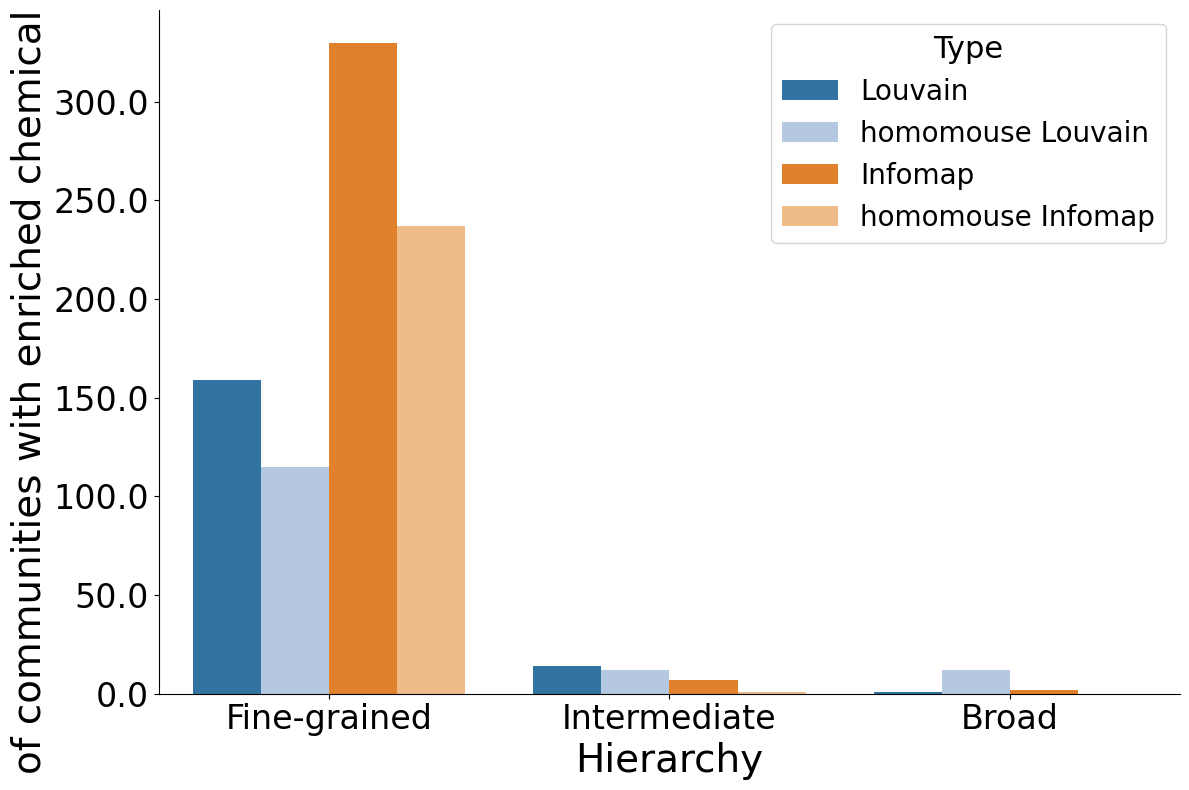

In [ ]:
import seaborn as sns
data = [
    ("Louvain", "Fine-grained", len([com for com in significant_gg_Louvain_fine_grained_dict.keys() if len(significant_gg_Louvain_fine_grained_dict[com])!=0])),
    ("Louvain", "Intermediate", len([com for com in significant_gg_Louvain_middle_dict.keys() if len(significant_gg_Louvain_middle_dict[com])!=0])),
    ("Louvain", "Broad", len([com for com in significant_gg_Louvain_broad_dict.keys() if len(significant_gg_Louvain_broad_dict[com])!=0])),
    ("homomouse Louvain", "Fine-grained", len([com for com in gg_homomouse_Louvain_fine_grained_dict.keys() if len(gg_homomouse_Louvain_fine_grained_dict[com])!=0])),
    ("homomouse Louvain",  "Intermediate", len([com for com in gg_homomouse_Louvain_middle_dict.keys() if len(gg_homomouse_Louvain_middle_dict[com])!=0])),
    ("homomouse Louvain",  "Broad", len([com for com in gg_homomouse_Louvain_broad_dict.keys() if len(gg_homomouse_Louvain_broad_dict[com])!=0])),
    ("Infomap",  "Fine-grained", len([com for com in significant_gg_Infomap_fine_grained_dict.keys() if len(significant_gg_Infomap_fine_grained_dict[com])!=0])),
    ("Infomap", "Intermediate",len([com for com in significant_gg_Infomap_middle_dict.keys() if len(significant_gg_Infomap_middle_dict[com])!=0])),
    ("Infomap",  "Broad", len([com for com in significant_gg_Infomap_broad_dict.keys() if len(significant_gg_Infomap_broad_dict[com])!=0])),
    ("homomouse Infomap", "Fine-grained", len([com for com in gg_homomouse_Infomap_fine_grained_dict.keys() if len(gg_homomouse_Infomap_fine_grained_dict[com])!=0])),
    ("homomouse Infomap", "Intermediate", len([com for com in gg_homomouse_Infomap_middle_dict.keys() if len(gg_homomouse_Infomap_middle_dict[com])!=0])),
]

df_plot = pd.DataFrame(data, columns=["Type", "Hierarchy", "Enriched_com"])

plt.figure(figsize=(12,8))

palette = {
    "Louvain": "#1f77b4",        # blue
    "homomouse Louvain": "#aec7e8", # light blue
    "Infomap": "#ff7f0e",        # orange
    "homomouse Infomap": "#ffbb78"  # light orange
}

ax = sns.barplot(
    x="Hierarchy", 
    y="Enriched_com", 
    hue="Type", 
    data=df_plot, 
    ci=None,
    palette = palette
)

# styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)



ax.set_yticklabels([str(i) for i in ax.get_yticks()], size=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Hierarchy", fontsize=28)
plt.ylabel("# of communities with enriched chemical terms", fontsize=28)

plt.legend(title="Type", fontsize=20, title_fontsize=22)
plt.tight_layout()
plt.savefig('output/Figures/HomomouseBipartite_CommunityEnrichment_comparison_GGN.pdf', format='pdf', dpi=300, bbox_inches="tight")
plt.show()